In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt
import numpy as np


In [3]:
train_data = datasets.FashionMNIST(root="data", download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, 'Ankle boot')

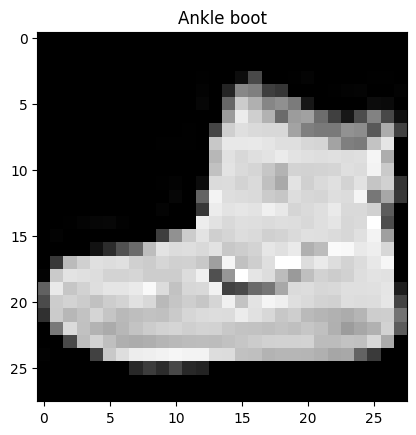

In [5]:
plt.imshow(train_data.data[0], cmap="gray")
plt.title(class_names[train_data.targets[0]])

In [6]:
BATCH_SIZE = 32


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")
print(f"Data loaders: {train_dataloader, test_dataloader}")

Length of train dataloader: 1875
Length of test dataloader: 313
Data loaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f704bd0ae40>, <torch.utils.data.dataloader.DataLoader object at 0x7f704bd1aad0>)


In [7]:
flatten_model = nn.Flatten()

x = train_features = next(iter(train_dataloader))[0][0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} --> Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28]) --> Shape after flattening: torch.Size([1, 784])


In [8]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [9]:
torch.manual_seed(42)

input_shape = 28 * 28
output_shape = len(class_names)
hidden_units = 10

device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = FashionMNISTModelV0(input_shape, hidden_units, output_shape)
model_0.to(device)



FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [10]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [11]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Total training time: {total_time:.2f} seconds")
    return total_time



In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

def train(model: nn.Module,
          dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred_class)
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%,")

def test(model: nn.Module,
         dataloader: DataLoader,
         loss_fn: nn.Module,
         device: torch.device = device):
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
            test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred_class)
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    
def complete_train_test_cycle(model: nn.Module,
                             train_dataloader: DataLoader,
                             test_dataloader: DataLoader,
                             loss_fn: nn.Module,
                             optimizer: torch.optim.Optimizer,
                             epochs: int,
                             device: torch.device = device):
    start_time = timer()
    model.to(device)
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}/{epochs}")
        train(model=model,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device)
        
        test(model=model,
             dataloader=test_dataloader,
             loss_fn=loss_fn,
             device=device)
        print("-----------------------------------------")
    end_time = timer()
    
    return print_train_time(start=start_time, end=end_time, device=device)


def eval_model(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               device: torch.device = device):
    model.eval()
    loss, acc = 0, 0
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            test_loss = loss_fn(y_pred, y)
            loss += test_loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            acc += accuracy_fn(y_true=y, y_pred=y_pred_class)
            
    loss /= len(data_loader)
    acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}


/home/prismoht/Desktop/diretorys/public/codes/tests/test4_pytoch/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# Training model

total_time_m0 = complete_train_test_cycle(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=5,
      device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Train loss: 0.42169 | Train accuracy: 85.21%,


 20%|██        | 1/5 [00:05<00:22,  5.68s/it]

Test loss: 0.46869 | Test accuracy: 83.27%
-----------------------------------------
Epoch: 2/5
Train loss: 0.42169 | Train accuracy: 85.21%,


 40%|████      | 2/5 [00:11<00:16,  5.65s/it]

Test loss: 0.46869 | Test accuracy: 83.27%
-----------------------------------------
Epoch: 3/5
Train loss: 0.42169 | Train accuracy: 85.21%,


 60%|██████    | 3/5 [00:16<00:11,  5.62s/it]

Test loss: 0.46869 | Test accuracy: 83.27%
-----------------------------------------
Epoch: 4/5
Train loss: 0.42169 | Train accuracy: 85.21%,


 80%|████████  | 4/5 [00:22<00:05,  5.67s/it]

Test loss: 0.46869 | Test accuracy: 83.27%
-----------------------------------------
Epoch: 5/5
Train loss: 0.42169 | Train accuracy: 85.21%,


100%|██████████| 5/5 [00:28<00:00,  5.72s/it]

Test loss: 0.46869 | Test accuracy: 83.27%
-----------------------------------------
Total training time: 28.60 seconds


In [41]:
# Evaluation
eval_results_m0 = eval_model(model=model_0,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

eval_results_m0

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46869391150558337,
 'model_acc': 83.2667731629393}

In [15]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [16]:
input_shape = 28 * 28
hidden_units = 10
output_shape = len(class_names)

model_1 = FashionMNISTModelV1(input_shape, hidden_units, output_shape)
model_1.to(device)

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

In [36]:
# Training model_1
total_time_m1 = complete_train_test_cycle(model=model_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=5,
      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Train loss: 0.37089 | Train accuracy: 86.65%,


 20%|██        | 1/5 [00:05<00:21,  5.39s/it]

Test loss: 0.43540 | Test accuracy: 84.43%
-----------------------------------------
Epoch: 2/5
Train loss: 0.37089 | Train accuracy: 86.65%,


 40%|████      | 2/5 [00:11<00:16,  5.65s/it]

Test loss: 0.43540 | Test accuracy: 84.43%
-----------------------------------------
Epoch: 3/5
Train loss: 0.37089 | Train accuracy: 86.65%,


 60%|██████    | 3/5 [00:16<00:11,  5.68s/it]

Test loss: 0.43540 | Test accuracy: 84.43%
-----------------------------------------
Epoch: 4/5
Train loss: 0.37089 | Train accuracy: 86.65%,


 80%|████████  | 4/5 [00:22<00:05,  5.82s/it]

Test loss: 0.43540 | Test accuracy: 84.43%
-----------------------------------------
Epoch: 5/5
Train loss: 0.37089 | Train accuracy: 86.65%,


100%|██████████| 5/5 [00:29<00:00,  5.84s/it]

Test loss: 0.43540 | Test accuracy: 84.43%
-----------------------------------------
Total training time: 29.19 seconds


In [37]:
# Evaluation
eval_results_m1 = eval_model(model=model_1,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)
eval_results_m1

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4354029896255499,
 'model_acc': 84.43490415335464}

In [28]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
            
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.block3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

In [30]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(1, 10, 10)
model_2.to(device)

FashionMNISTModelV2(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [48]:
# Training model_2
total_time_m2 = complete_train_test_cycle(model=model_2,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=5,
      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Train loss: 0.20361 | Train accuracy: 92.45%,


 20%|██        | 1/5 [00:07<00:29,  7.44s/it]

Test loss: 0.27304 | Test accuracy: 90.78%
-----------------------------------------
Epoch: 2/5
Train loss: 0.20093 | Train accuracy: 92.56%,


 40%|████      | 2/5 [00:14<00:21,  7.27s/it]

Test loss: 0.27902 | Test accuracy: 90.49%
-----------------------------------------
Epoch: 3/5
Train loss: 0.19972 | Train accuracy: 92.61%,


 60%|██████    | 3/5 [00:22<00:14,  7.42s/it]

Test loss: 0.27344 | Test accuracy: 90.59%
-----------------------------------------
Epoch: 4/5
Train loss: 0.20039 | Train accuracy: 92.63%,


 80%|████████  | 4/5 [00:29<00:07,  7.40s/it]

Test loss: 0.29258 | Test accuracy: 89.71%
-----------------------------------------
Epoch: 5/5
Train loss: 0.20001 | Train accuracy: 92.58%,


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]

Test loss: 0.29400 | Test accuracy: 90.11%
-----------------------------------------
Total training time: 37.14 seconds


In [39]:
# Evaluation
eval_results_m2 = eval_model(model=model_2,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)
eval_results_m2

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2858905866504096,
 'model_acc': 90.09584664536742}

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [51]:
import pandas as pd

compare_results = pd.DataFrame([eval_results_m0, eval_results_m1, eval_results_m2])
print( total_time_m0, total_time_m1, total_time_m2)
compare_results['training_time'] = [total_time_m0, total_time_m1, total_time_m2]
compare_results.head()


None None None


,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.468694,83.266773,None
1,FashionMNISTModelV1,0.435403,84.434904,None
2,FashionMNISTModelV2,0.285891,90.095847,None
